<a href="https://colab.research.google.com/github/samirapakravan/ML_Challenge/blob/main/PostEra_ML_Challenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

I was able to install RDKit using pip on colab

In [ ]:
pip install rdkit

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.3/29.3 MB 29.5 MB/s eta 0:00:00



#**Beginnin Problem**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.Chem import AllChem
from rdkit.Chem.Draw import IPythonConsole 

import warnings
warnings.filterwarnings('ignore')

Adding the columns cLogP, HBD, HBA to the dataframealong with other columns

In [ ]:
sub_df = pd.read_csv('https://covid.postera.ai/covid/submissions.csv')
sub_df = sub_df[['SMILES', 'CID', 'Submission Creator', 'Submission Rationale', 'MW', 'cLogP', 'HBD', 'HBA']]
#sub_df.info()

Applying Rule of 5 on dataframe and assigning the result to a new column 'ROF_violations', at this stage 'ROF_violations' will have up to 4 unique values.

Next  the dataframe has been filtered down to only those molecules that have <= 1 Rule of 5 and dataframe is called ROF_df

In [ ]:
sub_df['ROF_violations']= sub_df['HBD'].apply(lambda x: 1 if x>5 else 0) + sub_df['HBA'].apply(lambda x: 1 if x>10 else 0) + sub_df['MW'].apply(lambda x: 1 if x>500 else 0) + sub_df['cLogP'].apply(lambda x: 1 if x>5 else 0)

In [ ]:
ROF_df = sub_df[sub_df['ROF_violations'] <= 1]

Checking "ROF_violations" column to make sure it only has 0 or 1 

In [ ]:
ROF_df['ROF_violations'].unique()

array([0, 1])

**Looking for similar molecules**

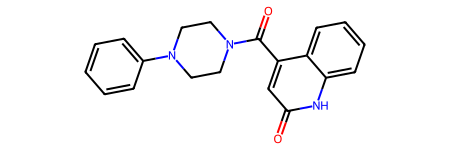

In [ ]:
SARS_mol = Chem.MolFromSmiles('O=C(c1cc(=O)[nH]c2ccccc12)N1CCN(c2ccccc2)CC1')
SARS_mol

In [ ]:
SARS_fp = np.array(AllChem.GetMorganFingerprintAsBitVect(SARS_mol,3,nBits=1024))

Creating a function that includes 3 similarity metrics: Cosine_Sim, Dice_Sim, Tanimoto_Sim

In [ ]:
def simFuncs(SARS_fp, fp, opt):
  if opt == 'Cosine_Sim':
    return np.sum(SARS_fp*fp) / np.sqrt(np.sum(SARS_fp)*np.sum(fp))
  
  elif opt == 'Dice_Sim':
    return np.sum(SARS_fp*fp)*2 / (np.sum(SARS_fp)+np.sum(fp))
  
  else:
    return np.sum(SARS_fp*fp) / (np.sum(SARS_fp)+np.sum(fp)-np.sum(SARS_fp*fp))

Applying metrics on data and add a new column for each metric

In [ ]:
funcOpt = ['Cosine_Sim','Dice_Sim','Tanimoto_Sim']

for i, row in ROF_df.iterrows():
  mol = Chem.MolFromSmiles(row['SMILES'])
  fp = np.array(AllChem.GetMorganFingerprintAsBitVect(mol, 3, nBits=1024))
  for opt in funcOpt:
    ROF_df.loc[i,opt] = simFuncs(SARS_fp, fp, opt)

In [ ]:
ROF_df.head()

,SMILES,CID,Submission Creator,Submission Rationale,MW,cLogP,HBD,HBA,ROF_violations,Cosine_Sim,Dice_Sim,Tanimoto_Sim
0,N#Cc1ccccc1NC(=O)Cc1c[nH]c2ncccc12,ANT-DIA-3c79be55-1,"Anthony Aimon, Diamond Light Source Ltd",Nitrile of X0305 seems to be key and superimpo...,276.299,2.61578,2.0,3.0,0,0.205136,0.205128,0.114286
1,N#Cc1ccccc1NC(=O)Cc1cccnc1,ANT-DIA-3c79be55-2,"Anthony Aimon, Diamond Light Source Ltd",Nitrile of X0305 seems to be key and superimpo...,237.262,2.13448,1.0,3.0,0,0.151620,0.150943,0.081633
2,CCNc1ccc(C#N)c(NC(=O)Cc2c[nH]c3ncccc23)c1,ANT-DIA-3c79be55-3,"Anthony Aimon, Diamond Light Source Ltd",Nitrile of X0305 seems to be key and superimpo...,319.368,3.04758,3.0,4.0,0,0.207002,0.206349,0.115044
3,CS(=O)(=O)Cc1ccc(C(=O)Nc2cccnc2)o1,ANT-DIA-3c79be55-4,"Anthony Aimon, Diamond Light Source Ltd",Nitrile of X0305 seems to be key and superimpo...,280.305,1.47150,1.0,5.0,0,0.147093,0.146789,0.079208
4,O=C(Nc1cccnc1)c1ccc(N2CCC(O)CC2)o1,ANT-DIA-3c79be55-5,"Anthony Aimon, Diamond Light Source Ltd",Nitrile of X0305 seems to be key and superimpo...,287.319,1.88800,2.0,5.0,0,0.212464,0.212389,0.118812


To test the correctness of my calculations, I redo the same process this time using the built-in metric functions available by importing  DataStructs

So 3 more columns will be added to this dataframe (this part can be ignored)

In [ ]:
from rdkit import DataStructs

SARS_fp = AllChem.GetMorganFingerprintAsBitVect(SARS_mol,3,nBits=1024)


for i, row in ROF_df.iterrows():
  mol = Chem.MolFromSmiles(row['SMILES'])
  fp = AllChem.GetMorganFingerprintAsBitVect(mol, 3, nBits=1024)
  ROF_df.loc[i,'Cosine_Sim2'] = DataStructs.FingerprintSimilarity(SARS_fp,fp,DataStructs.CosineSimilarity)
  ROF_df.loc[i,'Dice_Sim2'] = DataStructs.FingerprintSimilarity(SARS_fp,fp, DataStructs.DiceSimilarity)
  ROF_df.loc[i,'Tanimoto_Sim2'] = DataStructs.FingerprintSimilarity(SARS_fp,fp, DataStructs.TanimotoSimilarity)

In [ ]:
ROF_df['Cosine_Sim'].equals(ROF_df['Cosine_Sim2']) and ROF_df['Dice_Sim'].equals(ROF_df['Dice_Sim2']) and ROF_df['Tanimoto_Sim'].equals(ROF_df['Tanimoto_Sim2'])

True

Find the 5 most similar molecules to SARS_mol in ROF_df

In [ ]:
df = ROF_df.sort_values(by=['Cosine_Sim'], ascending=[False]).head(5)
Cosine_Sim_list = df[df.columns[0]].values.tolist()
Cosine_Sim_list

['O=C(c1cc(=O)[nH]c2ccccc12)N1CCN(c2ccccc2)CC1',
 'O=C(c1cc(=O)[nH]c2ccccc12)N1CCN(c2ccccc2)CC1',
 'O=C(c1cc(=O)[nH]c2ccccc12)N1CCN(c2ccc(F)cc2)CC1',
 'COc1ccc(N2CCN(C(=O)c3cc(=O)[nH]c4ccccc34)CC2)cc1',
 'COc1ccc(N2CCN(C(=O)c3cc(=O)[nH]c4ccccc34)CC2)cc1']

In [ ]:
df = ROF_df.sort_values(by=['Dice_Sim'], ascending=[False]).head(5)
Dice_Sim_list = df[df.columns[0]].values.tolist()
Dice_Sim_list

['O=C(c1cc(=O)[nH]c2ccccc12)N1CCN(c2ccccc2)CC1',
 'O=C(c1cc(=O)[nH]c2ccccc12)N1CCN(c2ccccc2)CC1',
 'O=C(c1cc(=O)[nH]c2ccccc12)N1CCN(c2ccc(F)cc2)CC1',
 'COc1ccc(N2CCN(C(=O)c3cc(=O)[nH]c4ccccc34)CC2)cc1',
 'COc1ccc(N2CCN(C(=O)c3cc(=O)[nH]c4ccccc34)CC2)cc1']

In [ ]:
df =ROF_df.sort_values(by=['Tanimoto_Sim'], ascending=[False]).head(5)
Tanimoto_Sim_list = df[df.columns[0]].values.tolist()
Tanimoto_Sim_list

['O=C(c1cc(=O)[nH]c2ccccc12)N1CCN(c2ccccc2)CC1',
 'O=C(c1cc(=O)[nH]c2ccccc12)N1CCN(c2ccccc2)CC1',
 'O=C(c1cc(=O)[nH]c2ccccc12)N1CCN(c2ccc(F)cc2)CC1',
 'COc1ccc(N2CCN(C(=O)c3cc(=O)[nH]c4ccccc34)CC2)cc1',
 'COc1ccc(N2CCN(C(=O)c3cc(=O)[nH]c4ccccc34)CC2)cc1']

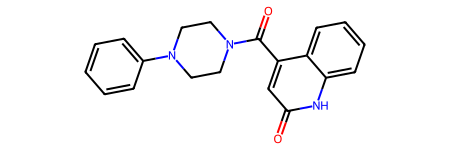

In [ ]:
SARS_mol = Chem.MolFromSmiles('O=C(c1cc(=O)[nH]c2ccccc12)N1CCN(c2ccccc2)CC1')
SARS_mol

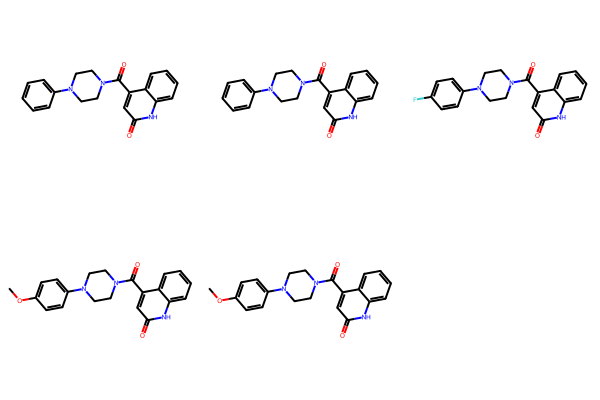

In [ ]:
Chem.Draw.MolsToGridImage(
    [Chem.MolFromSmiles(x) for x in Cosine_Sim_list]
)

In [ ]:
df

,SMILES,CID,Submission Creator,Submission Rationale,MW,cLogP,HBD,HBA,ROF_violations,Cosine_Sim,Dice_Sim,Tanimoto_Sim,Cosine_Sim2,Dice_Sim2,Tanimoto_Sim2
6013,O=C(c1cc(=O)[nH]c2ccccc12)N1CCN(c2ccccc2)CC1,EDJ-MED-78f964c8-1,"Ed J Griffen, MedChemica Ltd",Piperazine analogue of MAT-POS-916a2c5a-2 desi...,333.391,2.4905,1.0,3.0,0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
3791,O=C(c1cc(=O)[nH]c2ccccc12)N1CCN(c2ccccc2)CC1,MAT-POS-916a2c5a-4,"Matt Robinson, PostEra",https://pubchem.ncbi.nlm.nih.gov/bioassay/1890...,333.391,2.4905,1.0,3.0,0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
5478,O=C(c1cc(=O)[nH]c2ccccc12)N1CCN(c2ccc(F)cc2)CC1,BEN-DND-7e92b6ca-14,"Benjamin Perry, DNDi",Scanning SAR around the 4-amidoquinolones iden...,351.140,2.6300,1.0,3.0,0,0.881483,0.881356,0.787879,0.881483,0.881356,0.787879
9355,COc1ccc(N2CCN(C(=O)c3cc(=O)[nH]c4ccccc34)CC2)cc1,KRI-MAR-d2e3ef86-13,"Kristijan Vukovic, Mario Negri Institute for P...",The 28 chemicals are selected by the computati...,363.160,2.5000,1.0,4.0,0,0.846901,0.845528,0.732394,0.846901,0.845528,0.732394
5475,COc1ccc(N2CCN(C(=O)c3cc(=O)[nH]c4ccccc34)CC2)cc1,BEN-DND-7e92b6ca-11,"Benjamin Perry, DNDi",Scanning SAR around the 4-amidoquinolones iden...,363.160,2.5000,1.0,4.0,0,0.846901,0.845528,0.732394,0.846901,0.845528,0.732394



<br>

By checking the SMILES and the metrics it seems that 2 out of the 5 returened values are exactly the same as SARS_mol, however I'm not quite sure, if that is the case we can ignore them and pick 2 more from top of our dataframe like following:

<br>

In [ ]:
new_df = ROF_df[ROF_df['Tanimoto_Sim']<1].sort_values(by=['Tanimoto_Sim'], ascending=[False]).head(5)
Tanimoto_Sim_list = new_df[new_df.columns[0]].values.tolist()
Tanimoto_Sim_list

['O=C(c1cc(=O)[nH]c2ccccc12)N1CCN(c2ccc(F)cc2)CC1',
 'COc1ccc(N2CCN(C(=O)c3cc(=O)[nH]c4ccccc34)CC2)cc1',
 'COc1ccc(N2CCN(C(=O)c3cc(=O)[nH]c4ccccc34)CC2)cc1',
 'O=C(c1cc(=O)[nH]c2ccccc12)N1CCN(c2cccc(Cl)c2)CC1',
 'O=C(c1cc(=O)[nH]c2ccccc12)N1CCN(c2cccc(F)c2)CC1']

In [ ]:
new_df

,SMILES,CID,Submission Creator,Submission Rationale,MW,cLogP,HBD,HBA,ROF_violations,Cosine_Sim,Dice_Sim,Tanimoto_Sim,Cosine_Sim2,Dice_Sim2,Tanimoto_Sim2
5478,O=C(c1cc(=O)[nH]c2ccccc12)N1CCN(c2ccc(F)cc2)CC1,BEN-DND-7e92b6ca-14,"Benjamin Perry, DNDi",Scanning SAR around the 4-amidoquinolones iden...,351.14,2.63,1.0,3.0,0,0.881483,0.881356,0.787879,0.881483,0.881356,0.787879
5475,COc1ccc(N2CCN(C(=O)c3cc(=O)[nH]c4ccccc34)CC2)cc1,BEN-DND-7e92b6ca-11,"Benjamin Perry, DNDi",Scanning SAR around the 4-amidoquinolones iden...,363.16,2.50,1.0,4.0,0,0.846901,0.845528,0.732394,0.846901,0.845528,0.732394
9355,COc1ccc(N2CCN(C(=O)c3cc(=O)[nH]c4ccccc34)CC2)cc1,KRI-MAR-d2e3ef86-13,"Kristijan Vukovic, Mario Negri Institute for P...",The 28 chemicals are selected by the computati...,363.16,2.50,1.0,4.0,0,0.846901,0.845528,0.732394,0.846901,0.845528,0.732394
13726,O=C(c1cc(=O)[nH]c2ccccc12)N1CCN(c2cccc(Cl)c2)CC1,ERI-UCB-a0b0dbcb-2,"Eric Jnoff, UCB",Visual alignment to the crystal structure of M...,367.11,3.14,1.0,3.0,0,0.837079,0.836066,0.718310,0.837079,0.836066,0.718310
5479,O=C(c1cc(=O)[nH]c2ccccc12)N1CCN(c2cccc(F)c2)CC1,BEN-DND-7e92b6ca-15,"Benjamin Perry, DNDi",Scanning SAR around the 4-amidoquinolones iden...,351.14,2.63,1.0,3.0,0,0.830614,0.829268,0.708333,0.830614,0.829268,0.708333


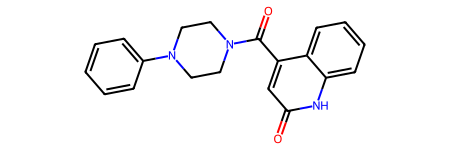

In [ ]:
SARS_mol = Chem.MolFromSmiles('O=C(c1cc(=O)[nH]c2ccccc12)N1CCN(c2ccccc2)CC1')
SARS_mol

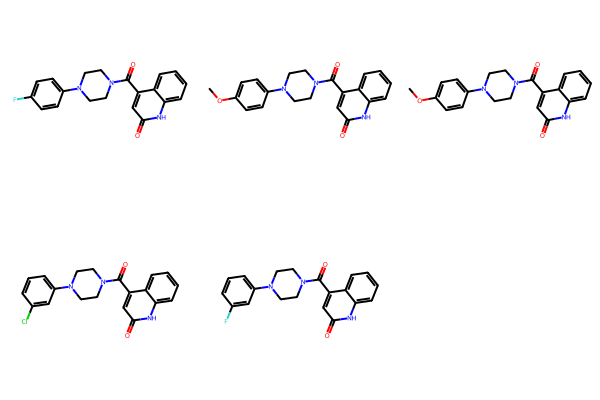

In [ ]:
Chem.Draw.MolsToGridImage(
    [Chem.MolFromSmiles(x) for x in Tanimoto_Sim_list]
)






---



---


---



#**Medium Problem**

In [ ]:
from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.Chem import AllChem
from rdkit.Chem.Draw import IPythonConsole 

import numpy as np
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from torch.utils.data import TensorDataset, DataLoader
from torch.optim.lr_scheduler import StepLR
from torch.optim.lr_scheduler import ReduceLROnPlateau
from tqdm.notebook import trange

# CUDA for PyTorch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.backends.cudnn.benchmark = True

Reading file contents and filtering the SMILES to those with at most 50 characters:

In [ ]:
zinc_df = pd.read_csv('SMILES_Keyboard.csv')
zinc_df = zinc_df.loc[zinc_df['SMILES'].str.len()<50][['SMILES', 'NAME']].reset_index(drop=True)

##**Method 1:** Natural Language Processing technique; i.e., neighborhood in latent space.



###**Tokenization and Encoding** 

Tokenizer function to separate SMILES strings into separate tokens:

In [ ]:
def smi_tokenizer(smi):
    """
    Tokenize a SMILES molecule or reaction
    """
    import re
    pattern =  "(\[[^\]]+]|Br?|Cl?|N|O|S|P|F|I|b|c|n|o|s|p|\(|\)|\.|=|#|-|\+|\\\\|\/|:|~|@|\?|>|\*|\$|\%[0-9]{2}|[0-9])"
    regex = re.compile(pattern)
    tokens = [token for token in regex.findall(smi)]
    assert smi == ''.join(tokens)
    return ' '.join(tokens)

Finding all the unique tokens and encoding the entire dataset using 2 dictionaries that convert token to integer and integer to token

In [ ]:
tokenized_data = ""
for i, row in zinc_df.iterrows():
  t = smi_tokenizer(row['SMILES'])
  tokenized_data += ' ' + t                     

tokenSet = set()
txt = []
for token in tokenized_data.split(" "):
  txt.append(token)
  tokenSet.add(token)

int2token = dict(enumerate(tokenSet))
token2int = {t: id for id, t in int2token.items()}
encoded = np.array([token2int[t] for t in txt])       # Encoded version of the entire dataset

Creating one-hot-encoding: creating column vector based on the integer values of tokens

In [ ]:
def one_hot_encode(encoded, n_uni_tokens):
    one_hot = np.zeros((encoded.size, n_uni_tokens), dtype=np.float32)  # Starting with zeros
    one_hot[np.arange(one_hot.shape[0]), encoded.flatten()] = 1.0       # Wherever index position meets set it 1
    one_hot = one_hot.reshape((*encoded.shape, n_uni_tokens))           # Reshape to get the original batch shape   
    return one_hot

###**Generating Training Batches** 

Each training sample is a sequence of tokens along with a label which is the same sequence shifted by 1 time step

In [ ]:
def generate_batches(encoded, batch_size, seq_len):
    token_per_batch = batch_size * seq_len            # Total number of tokens per batch
    n_batches = len(encoded)//token_per_batch         # Total number of batches we can make out of all data
    
    encoded = encoded[:n_batches * token_per_batch]   # Cut of the end of encode
    encoded = encoded.reshape((batch_size, -1))       # Reshape encoded data into rows of size batch
    
    for n in range(0, encoded.shape[1], seq_len):     # Encoded is reshaped now, so we go along dimension 1
        x = encoded[:, n:n+seq_len]
        y = np.zeros_like(x)                          # Creating array of zeros with same shape as x
        
        try:
            y[:,:-1] = x[:,1:]
            y[:,-1] = encoded[:,n+seq_len]       
        except:                                       # At the end there is a possibility to go out of range
            y[:,:-1] = x[:,1:]
            y[:,-1] = encoded[:,0]
        yield x, y

###**Creating NN Model** 

This model is equivalent to a character level model in NLP.

The network will be trained token by token on an encoded dataset of all tokenized SMILES and it will generate SMILES token by token

The LSTM layer has been used in this model

In [ ]:
class Model(nn.Module):
    
    def __init__(self, tokens, n_hidden=10, n_layers=2):
        super().__init__()

        self.n_layers = n_layers
        self.n_hidden = n_hidden

        # our built-in dictionaries
        self.tokens = tokens
        self.int2token = dict(enumerate(self.tokens))
        self.token2int = {t: id for id, t in int2token.items()}
        
        self.lstm = nn.LSTM(len(self.tokens), n_hidden, n_layers, dropout=0.2, batch_first=True)   # batch_first=True --> (batch, seq, feature)
        self.dropout = nn.Dropout(0.2)                                                             # Dropout layer to avoid overfitting
        self.fc = nn.Linear(n_hidden, len(self.tokens)) 

    def forward(self, x, hidden):
        lstm_out, hidden = self.lstm(x, hidden)      
        out = self.dropout(lstm_out)  
        out = out.contiguous().view(-1, self.n_hidden)       # Correct the view so we can pass it to the fc layer    
        out = self.fc(out)   
        return out, hidden   

    def hidden_state(self, batch_size):
        hidden = (torch.zeros(self.n_layers, batch_size, self.n_hidden).to(device), torch.zeros(self.n_layers, batch_size, self.n_hidden).to(device))        
        return hidden


In [ ]:
n_hidden=50
n_layers=3
model = Model(tokenSet, n_hidden, n_layers).to(device)
print(model)

Model(
  (lstm): LSTM(55, 50, num_layers=3, batch_first=True, dropout=0.2)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc): Linear(in_features=50, out_features=55, bias=True)
)


###**Training the Model** 

Splitting the data into train and test datasets

In [ ]:
indx = int(len(encoded)*(1-0.1))
train, test = encoded[:indx], encoded[indx:]

Defining optimizer and loss function 

In [ ]:
lr = 0.005
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
loss_fn = nn.CrossEntropyLoss()

Defining parameters 

In [ ]:
epochs = 50
b = 0
batch_size = 128
seq_length = 50
n_uni_tokens = len(model.tokens)

Training loop

In [ ]:
model.train()

for i in range(epochs):
    h = model.hidden_state(batch_size)
    
    for x, y in generate_batches(train, batch_size, seq_length):    # Creating input and target batches
        b += 1

        x = one_hot_encode(x, n_uni_tokens)                         # Creating one_hot_encoding of input
        inputs, targets = torch.from_numpy(x), torch.from_numpy(y)  # Creating a Tensor from a numpy.ndarray
        inputs, targets = inputs.to(device), targets.to(device)     # Using available device

        h = tuple([each.data for each in h]) # Resetting the hidden state, if we don't reset it, it will backprop into all training

        optimizer.zero_grad()
        
        output, h = model(inputs, h)     
        loss = loss_fn(output, targets.view(batch_size*seq_length).long())  # Calculating the loss with correct shape of target
        loss.backward()                                                     # Performs backpropagation
        optimizer.step()     # Updates the value of parameters according to the optimization strategy
        
        if b % 100 == 0:
            val_h = model.hidden_state(batch_size)
            val_losses = []
            model.eval()      # Changing to evaluation mode and doing the same process on test data

            for x, y in generate_batches(test, batch_size, seq_length):
                x = one_hot_encode(x, n_uni_tokens)
                x, y = torch.from_numpy(x), torch.from_numpy(y)

                val_h = tuple([each.data for each in val_h])
                
                inputs, targets = x, y
                inputs, targets = inputs.to(device), targets.to(device)

                output, val_h = model(inputs, val_h)
                val_loss = loss_fn(output, targets.view(batch_size*seq_length).long())
            
                val_losses.append(val_loss.item())
            
            model.train()      # Changing back to evaluation mode
            print(f"Epoch:{i}   Loss:{loss.item()}    Val_Loss: {np.mean(val_losses)}")


Epoch:1   Loss:2.3373095989227295    Val_Loss: 2.3280267318089805
Epoch:3   Loss:1.9556472301483154    Val_Loss: 1.9328383008639018
Epoch:5   Loss:1.7076448202133179    Val_Loss: 1.6521549423535664
Epoch:7   Loss:1.6034549474716187    Val_Loss: 1.5337611436843872
Epoch:8   Loss:1.4792097806930542    Val_Loss: 1.4463388125101726
Epoch:10   Loss:1.426172137260437    Val_Loss: 1.380546748638153
Epoch:12   Loss:1.3626774549484253    Val_Loss: 1.3407535155614216
Epoch:14   Loss:1.3205933570861816    Val_Loss: 1.3107359011967976
Epoch:15   Loss:1.3024358749389648    Val_Loss: 1.2827066381772358
Epoch:17   Loss:1.257061243057251    Val_Loss: 1.2600040038426716
Epoch:19   Loss:1.2755206823349    Val_Loss: 1.22804989417394
Epoch:21   Loss:1.179123044013977    Val_Loss: 1.2085735599199932
Epoch:22   Loss:1.1752290725708008    Val_Loss: 1.1958153049151103
Epoch:24   Loss:1.1480222940444946    Val_Loss: 1.1853307485580444
Epoch:26   Loss:1.1375137567520142    Val_Loss: 1.1577343344688416
Epoch:28 

To monitor the performance and avoid overfitting, both train and validation loss are printed, if the the training loss become much smaller than validation loss, our model is overfitting, in that case we can add regularizaer or adjust dropout 


###**Generating Prediction** 

The following function predicts at token level meaning given the model and a token it will return the next token 

In [ ]:
def predict(model, token, hidden=None, top_k=1):

  encoded_text = model.token2int[token]                           # Encode the token                  
  encoded_text = np.array([[encoded_text]])
  encoded_text = one_hot_encode(encoded_text, len(model.tokens))  # one-hot-encode the token
  encoded_text = torch.from_numpy(encoded_text)
  encoded_text = encoded_text.to(device)

  hidden = tuple([state.data for state in hidden])
  out, hidden = model(encoded_text, hidden)                       # Run the model

  probs = F.softmax(out, dim=1).data                              # Convert out to probabilities
  probs = probs.cpu()

  probs, index = probs.topk(top_k)                            # Returns the top ks
  
  index = index.numpy().squeeze()
  probs = probs.numpy().squeeze()

  token = np.random.choice(index, p=probs/probs.sum())   # Convert probabilities per index and chose token based on that
  
  return model.int2token[token], hidden

The following function generates as many as tokens as asked using the above function. We only conside k most probable tokens to prevent recieving totally unrelated tokens while allowing to have some randomness.


In [ ]:
def generate_sample(model, size, prefix='', top_k=1):  # size: how many tokens we want to predict

  model.to(device)          
  model.eval() 

  tokenized_prefix = smi_tokenizer(prefix)          # Converting prefix to a tokenized version
  output_tokens = [c for c in tokenized_prefix.split(" ")]
  
  hidden = model.hidden_state(1)

  # Predicting the next token for every token in the tokenized_prefix
  for t in tokenized_prefix.split(" "):  
    t, hidden = predict(model, t, hidden, top_k=top_k)
  output_tokens.append(t)
  
  # Generating for the requested size
  for i in range(size):
      t, hidden = predict(model, output_tokens[-1], hidden, top_k=top_k)  # This time we generate based on the last thing we predicted
      output_tokens.append(t)
  
  return ''.join(output_tokens)

The following function generates valid samples based on the given prefix and reports up to 5 similar valid samples, a timer has been used for the cases that there are not enough valid samples to avoid infinit loop.

In [ ]:
import time
def result(prefix):
  s = set()
  timeout = 25
  start=time.time() 
  while len(s)<6:
    result = generate_sample(model, 2, prefix=prefix, top_k=10)
    mol = Chem.MolFromSmiles(result)
    if result not in s and mol:
      print(f'SMI:  {result}')
      s.add(result)

    if time.time()>(timeout+start):
      print('End of Search')
      break

In [ ]:
prefix = input('Please enter your prefix: ')
result(prefix)

Please enter your prefix: CCc1ccc
SMI:  CCc1ccccc1
SMI:  CCc1cccnc1
SMI:  CCc1ccccn1
SMI:  CCc1cccnn1
SMI:  CCc1cccc[n+]1
SMI:  CCc1ccc[n+]c1


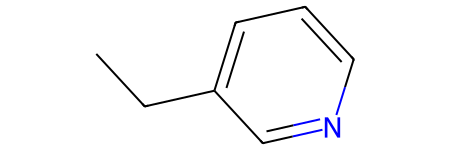

In [ ]:
Chem.MolFromSmiles('CCc1cccnc1')

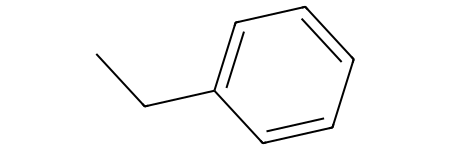

In [ ]:
Chem.MolFromSmiles('CCc1ccccc1')

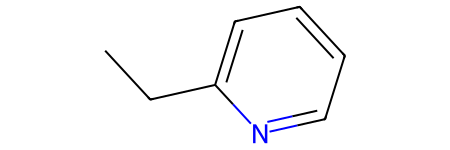

In [ ]:
Chem.MolFromSmiles('CCc1ccccn1')

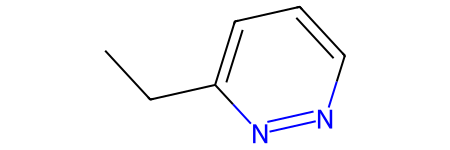

In [ ]:
Chem.MolFromSmiles('CCc1cccnn1')

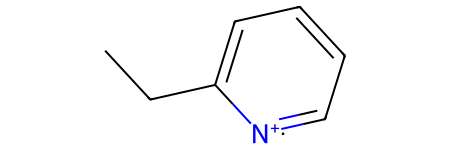

In [ ]:
Chem.MolFromSmiles('CCc1cccc[n+]1')

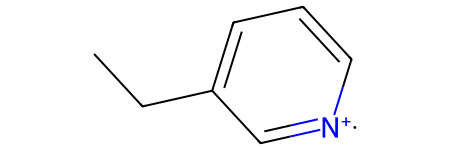

In [ ]:
Chem.MolFromSmiles('CCc1ccc[n+]c1')

  


---



##**Method 2:** Classic database query using Trie

I was interested in exploring other methods on this dataset such as tri so used pygtrie

In [ ]:
pip install pygtrie

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pygtrie
trie = pygtrie.CharTrie()
for smile in zinc_df.SMILES:
  trie[smile] = True
trie['exit'] = False

In [ ]:
def find_topK(trie, text, k=5):
  value = trie.get(text)
  if value is not None:
      print(repr(text), 'is a smile in database')
  if trie.has_subtrie(text):
      print(repr(text), 'is a prefix of a smile')
  else:
      print(repr(text), 'is not a prefix, going back to empty string')
      return None
  candidates = trie.keys(text)
  # because with a few prefixes it is likely to predict smaller extensions
  hits = sorted(candidates, key=len)[:k]
  for hit in hits:
    print(f"\t {hit}")

In [ ]:
text = 'CCc1ccc'
find_topK(trie, text, k=5)

'CCc1ccc' is a prefix of a smile
	 CCc1ccc(Cl)oc1=O
	 CCc1ccc(=O)oc1Cl
	 CCc1ccccc1N1CCNCC1
	 CCc1ccccc1OCC1=NCCN1
	 CCc1cccc(C2=NCCN2)c1
